In [355]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from matplotlib.pylab import rcParams

from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE

In [356]:
rcParams['figure.figsize'] = 15, 6

In [357]:
path_matlab = "../../data/series/series_matlab.csv"
path_fires = "../../data/series/series_fires_acre.csv"

series_matlab = pd.read_csv(path_matlab)
series_fires = pd.read_csv(path_fires, encoding='ISO-8859-1')

In [358]:
series_fires

,date,number
0,1998-01-01,0.000
1,1998-02-01,0.000
2,1998-03-01,0.000
3,1998-04-01,0.000
4,1998-05-01,0.000
...,...,...
234,2017-07-01,457.000
235,2017-08-01,1.493
236,2017-09-01,3.429
237,2017-10-01,1.508


In [359]:
series_fires['date'] = pd.to_datetime(series_fires['date'])

In [360]:
series_fires = series_fires.set_index('date')

<Axes: xlabel='date'>

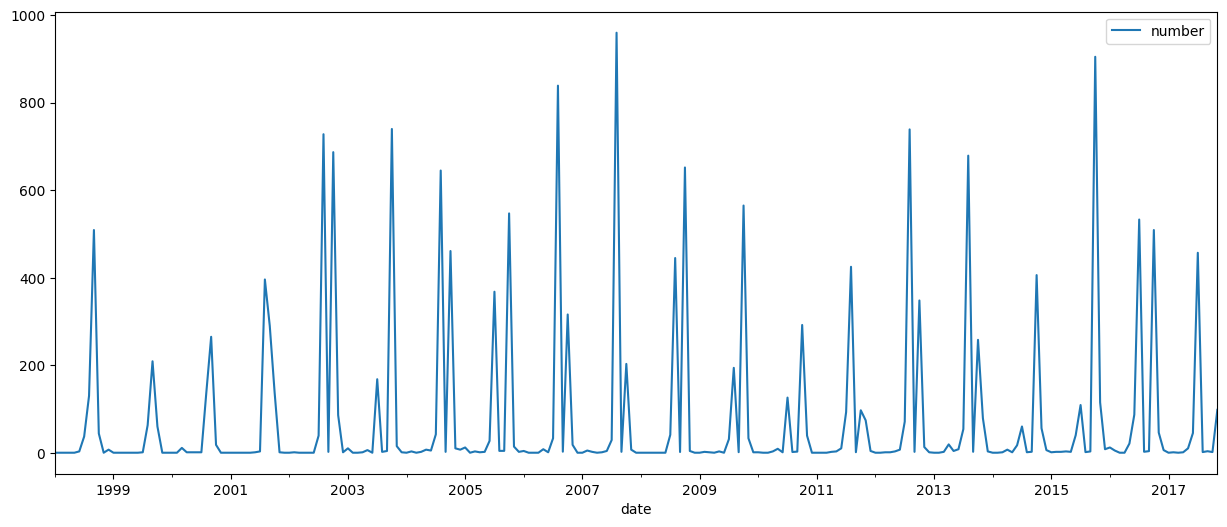

In [361]:
series_fires.plot()

In [362]:
train_fires, val_fires, test_fires = series_fires.loc['1998':'2013'], series_fires.loc['2014':'2015'], series_fires.loc['2016':'2017']

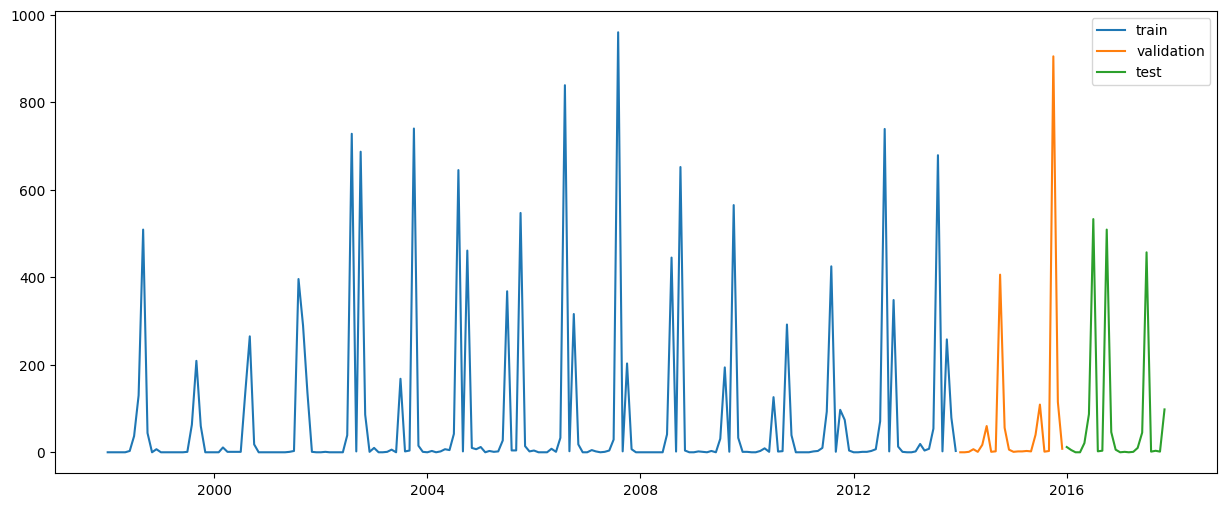

In [363]:
plt.plot(train_fires, label = 'train')
plt.plot(val_fires, label = 'validation')
plt.plot(test_fires, label = 'test')
plt.legend(loc = 'best')
plt.show()

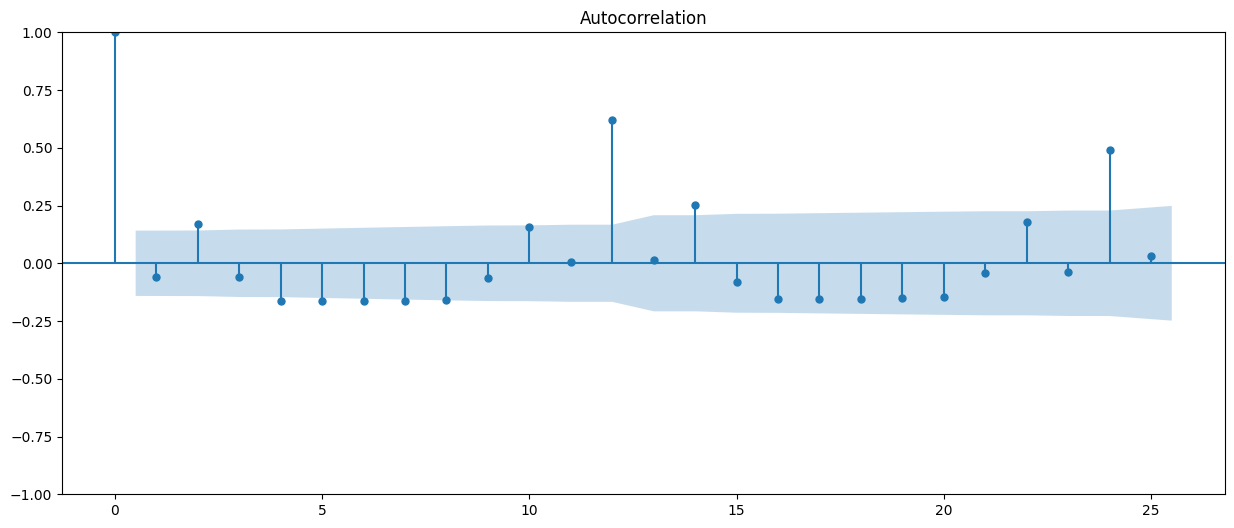

In [364]:
sm.graphics.tsa.plot_acf(train_fires, lags=25)
plt.show()

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


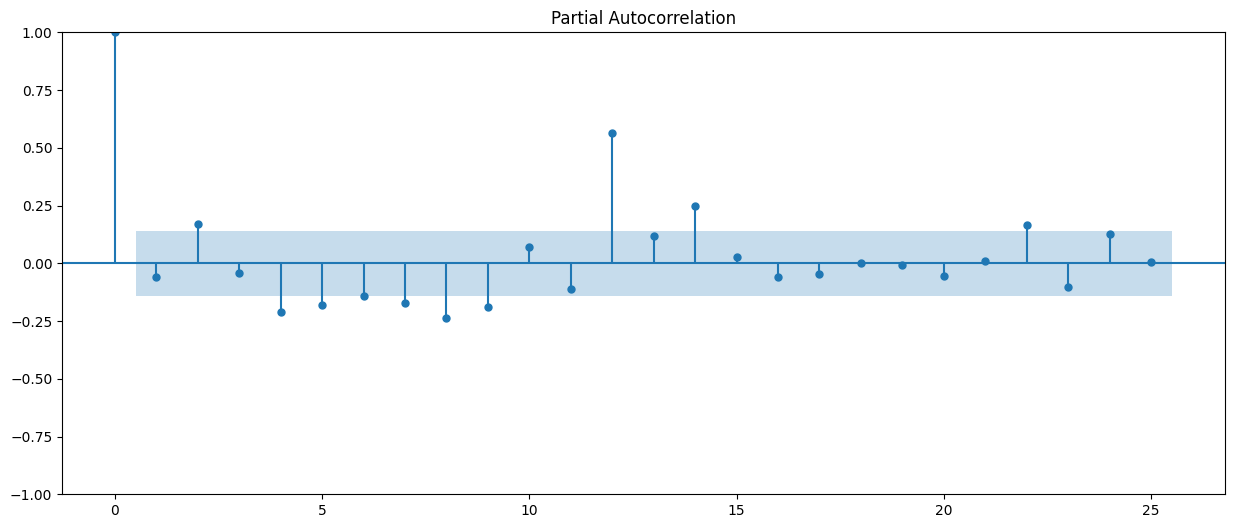

In [365]:
fig = sm.graphics.tsa.plot_pacf(train_fires, lags=25)
plt.show()

In [366]:
def create_sliding_windows(series, window_size):

    list_of_sliding_windows = []
    list_size_to_iterate = len(series) - window_size
    for i in range(0, list_size_to_iterate):
        window = series[i: i + window_size + 1]
        list_of_sliding_windows.append(window)

    return np.array(list_of_sliding_windows).reshape(len(list_of_sliding_windows), window_size+1)

In [367]:
train_windows = create_sliding_windows(train_fires, 12)
val_windows = create_sliding_windows(val_fires, 12)
test_windows = create_sliding_windows(test_fires, 12)

In [368]:
X_train = train_windows[:, 0:-1]
y_train = train_windows[:, -1]

X_val = val_windows[: ,0: -1]
y_val = val_windows[: , -1]

X_test = test_windows[: ,0: -1]
y_test = test_windows[: , -1]

## Decision Tree Regressor

In [369]:
criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
splitter = ['best', 'random']


best_mse = np.inf
best_criterion = None
best_splitter = None

for c in criterion:
  for s in splitter:
    modelo = DecisionTreeRegressor(criterion=c, splitter=s)
    modelo.fit(X_train, y_train)
    prev_val = modelo.predict(X_val)

    mse = MSE(y_val, prev_val)
    if mse < best_mse:
        best_mse = mse
        best_criterion = c
        best_splitter = s

In [370]:
(best_criterion, best_splitter, best_mse)

('friedman_mse', 'random', 18745.271436166666)

In [371]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [372]:
modelo = DecisionTreeRegressor(criterion=best_criterion, splitter=best_splitter)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

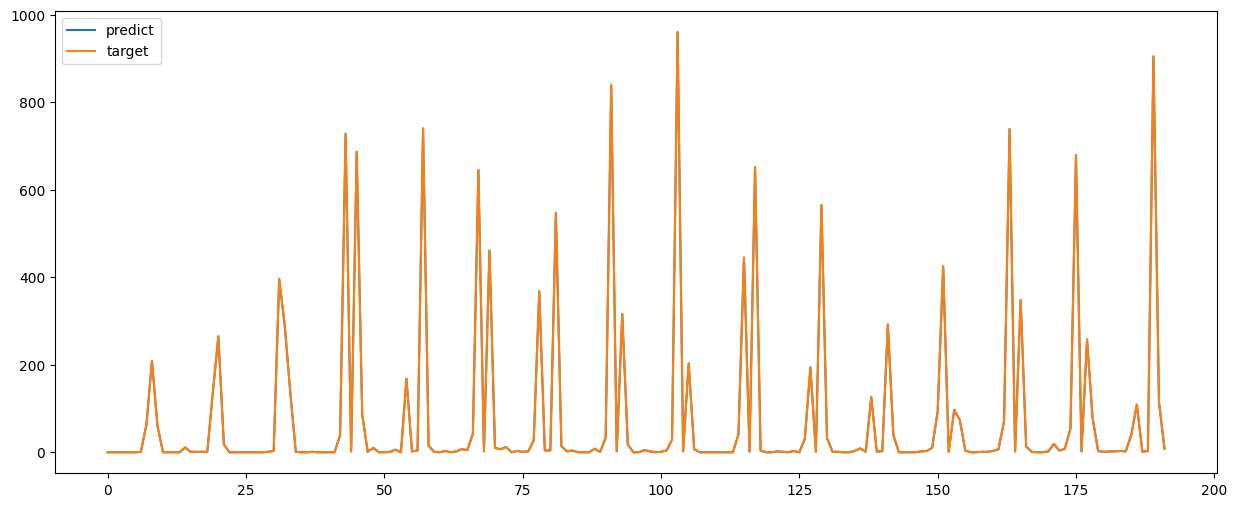

In [373]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [374]:
MSE(y_train_full, prev_train)

0.0

In [375]:
prev_test = modelo.predict(X_test)

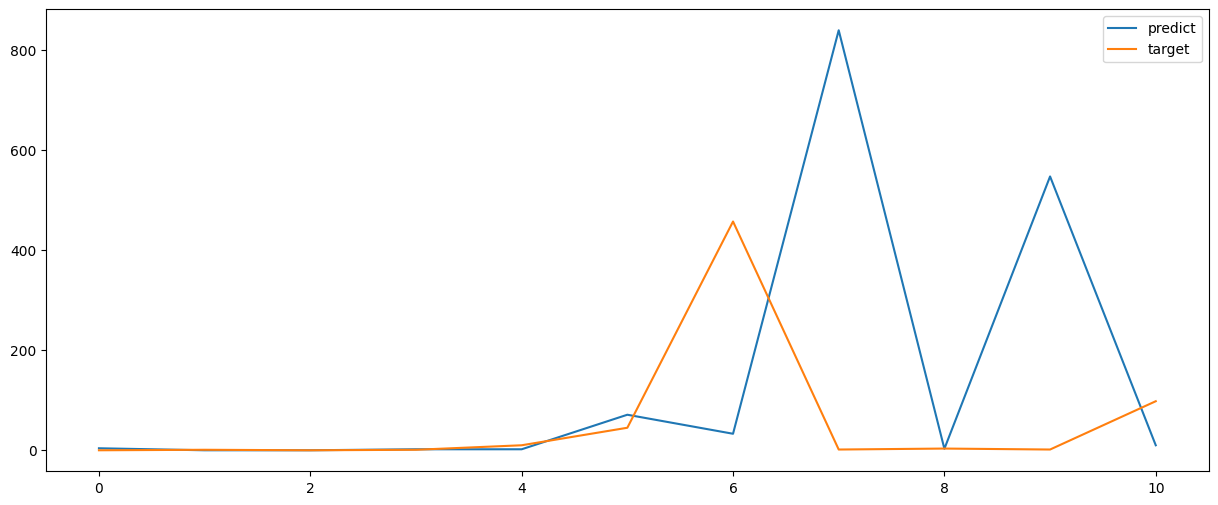

In [376]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [377]:
MSE(y_test, prev_test)

107932.51646854544

### Hyperparameters Tuning

In [378]:
criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
splitter = ['best', 'random']
max_depths = [2, 3, 4, 5, 6, 7, 8, 10, 15]
min_samples_split = [2,3,4,5,6]
min_samples_leaf = [1,2,3,4,5]
ccp_alphas = [0.0, 0.001, 0.002, 0.003, 0.004]

best_mse = np.inf
best_criterion = None
best_splitter = None
best_depth = None
best_min_samples_split = None
best_min_samples_leaf = None
best_ccp_alpha = None

for c in criterion:
  for s in splitter:
    for m in max_depths:
      for mss in min_samples_split:
        for msl in min_samples_leaf:
          for ccp_alpha in ccp_alphas:
            modelo = DecisionTreeRegressor(criterion=c, splitter=s, max_depth=m, min_samples_split=mss, min_samples_leaf=msl, ccp_alpha=ccp_alpha)
            modelo.fit(X_train, y_train)
            prev_val = modelo.predict(X_val)

            mse = MSE(y_val, prev_val)
            if mse < best_mse:
              best_mse = mse
              best_criterion = c
              best_splitter = s
              best_depth = m
              best_min_samples_split = mss
              best_min_samples_leaf = msl
              best_ccp_alpha = ccp_alpha

In [379]:
(best_criterion, best_splitter, best_depth, best_min_samples_split, best_min_samples_leaf, best_ccp_alpha, best_mse)

('friedman_mse', 'random', 7, 4, 1, 0.004, 2568.6604732393444)

In [380]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [381]:
modelo = DecisionTreeRegressor(criterion=best_criterion, splitter=best_splitter, max_depth=best_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, ccp_alpha=best_ccp_alpha)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

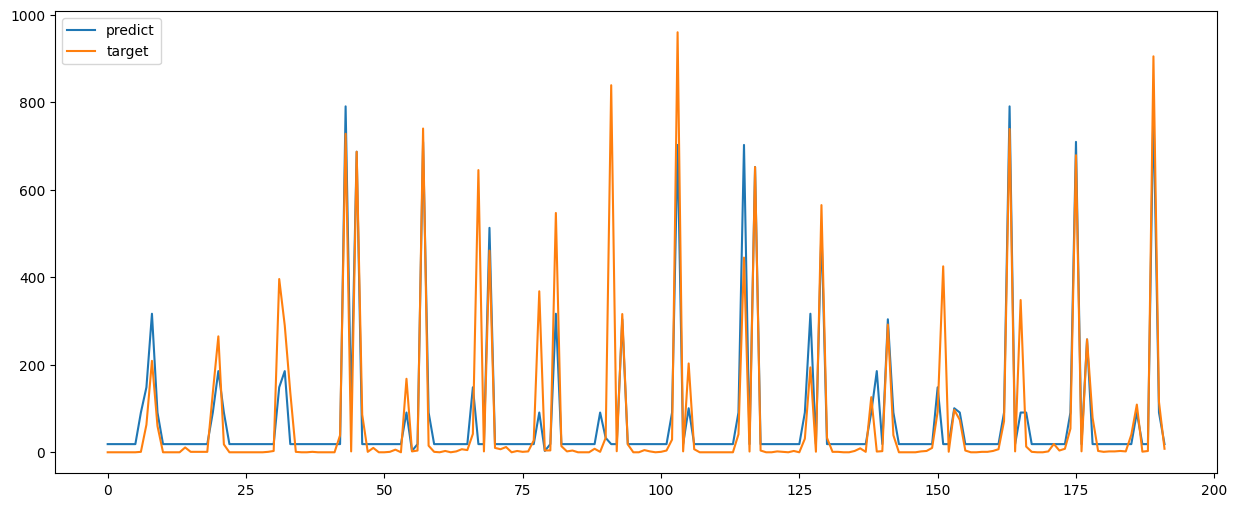

In [382]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [383]:
MSE(y_train_full, prev_train)

9825.735850610867

In [384]:
prev_test = modelo.predict(X_test)

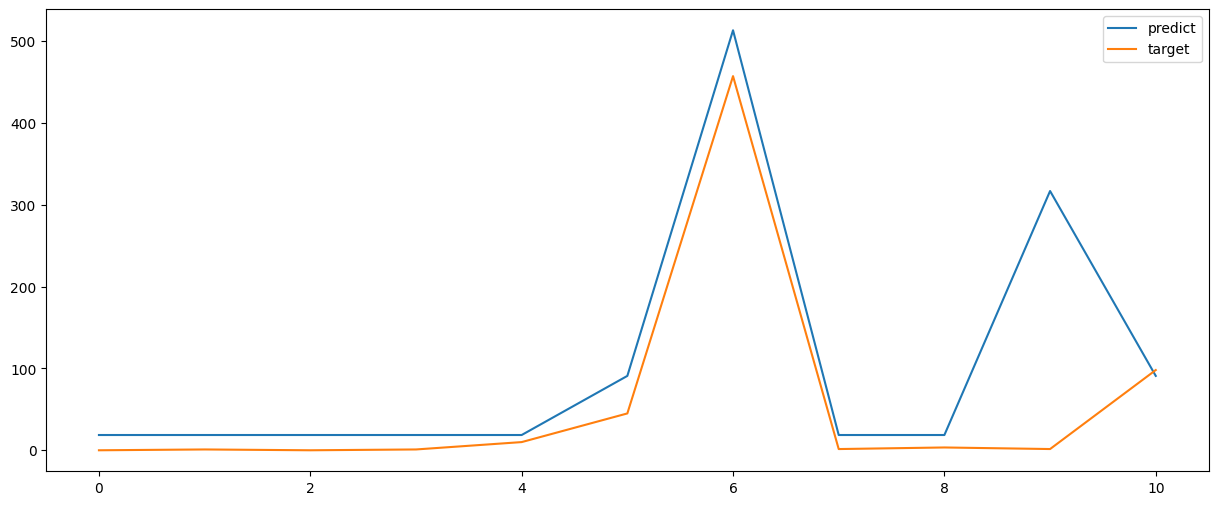

In [385]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [386]:
MSE(y_test, prev_test)

9684.817968470834

## MLPRegressor

In [ ]:
activation = ['identity', 'logistic', 'tanh', 'relu']
solver = ['lbfgs', 'sgd', 'adam']
learning_rate = ['constant', 'invscaling', 'adaptive']

best_mse = np.inf
best_activation = None
best_solver = None
best_learning_rate = None

for a in activation:
  for s in solver:
    for l in learning_rate:
        try:
           
          modelo = MLPRegressor(activation=a, solver=s, learning_rate=l)
          modelo.fit(X_train, y_train)
          prev_val = modelo.predict(X_val)
        
        except:
           print(a,s,l)

        mse = MSE(y_val, prev_val)
        if mse < best_mse:
            best_mse = mse
            best_activation = a
            best_solver = s
            best_learning_rate = l

In [388]:
(best_activation, best_solver, best_learning_rate, best_mse)

('logistic', 'lbfgs', 'adaptive', 13684.700002202584)

In [389]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [ ]:
modelo = MLPRegressor(activation=best_activation, solver=best_solver, learning_rate=best_learning_rate)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

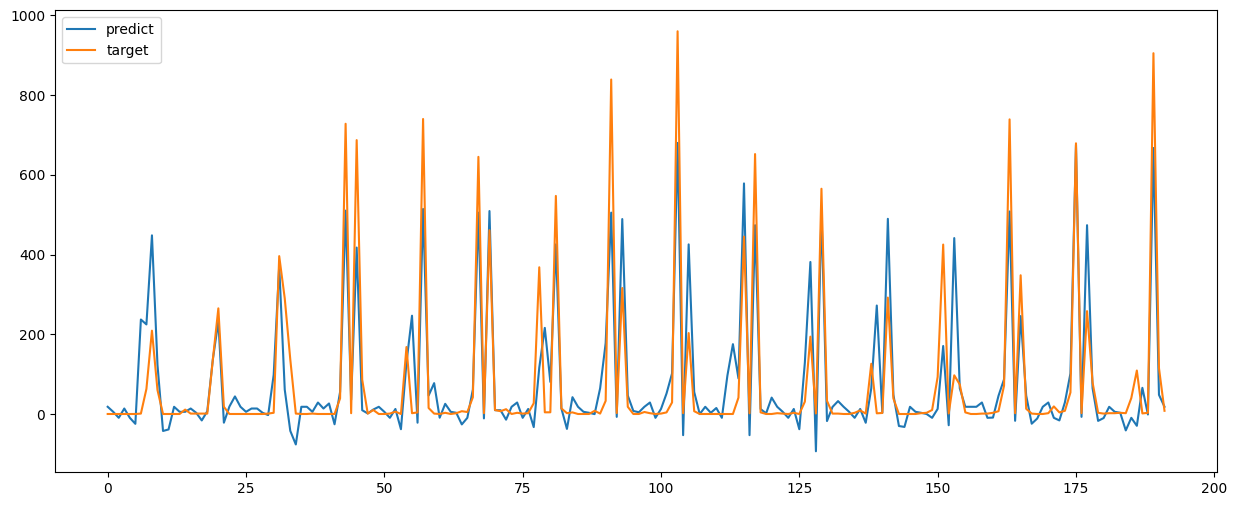

In [391]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [392]:
MSE(y_train_full, prev_train)

8642.775326225512

In [393]:
prev_test = modelo.predict(X_test)

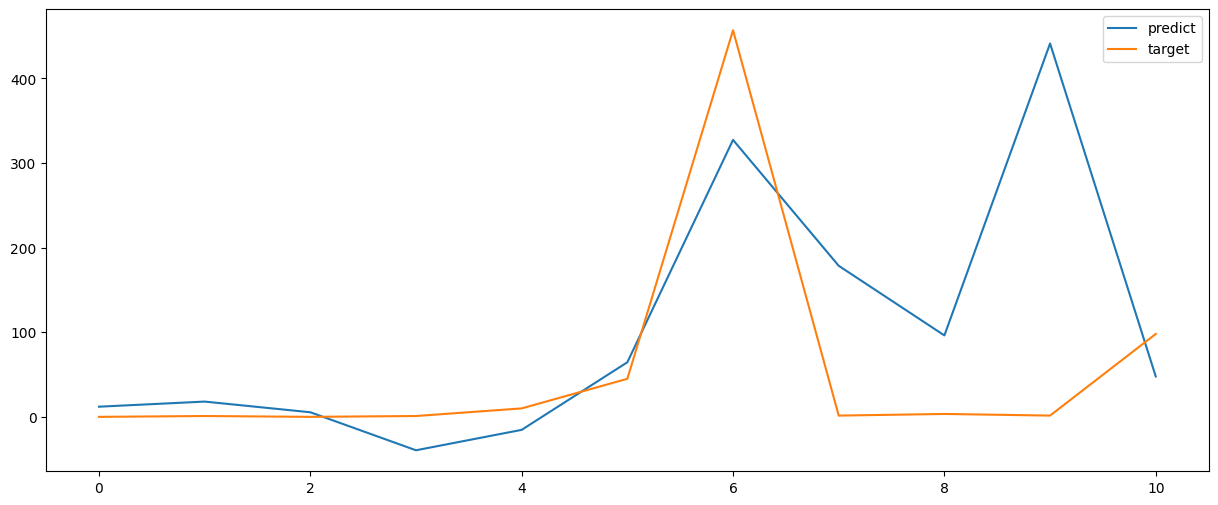

In [394]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [395]:
MSE(y_test, prev_test)

23264.35783802463

## KNeighborsRegressor

In [396]:
neighbors = [1,2,3,4,5,6,7,8,9,10,11,12,13]
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_size = [1,2,3,4,5,10,15,20]

best_mse = np.inf
best_neighbors = None
best_weights = None
best_algorithm = None
best_leaf_size = None

for n in neighbors:
  for w in weights:
    for a in algorithm:
      for l in leaf_size:
        modelo = KNeighborsRegressor(n_neighbors=n, weights=w, algorithm=a, leaf_size=l)
        modelo.fit(X_train, y_train)
        prev_val = modelo.predict(X_val)

        mse = MSE(y_val, prev_val)
        if mse < best_mse:
            best_mse = mse
            best_neighbors = n
            best_weights = w
            best_algorithm = a
            best_leaf_size = l

In [397]:
(best_neighbors, best_weights, best_algorithm, best_leaf_size, best_mse)

(7, 'uniform', 'auto', 1, 22032.34045277211)

In [398]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [399]:
modelo = KNeighborsRegressor(n_neighbors=best_neighbors, weights=best_weights, algorithm=best_algorithm, leaf_size=best_leaf_size)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

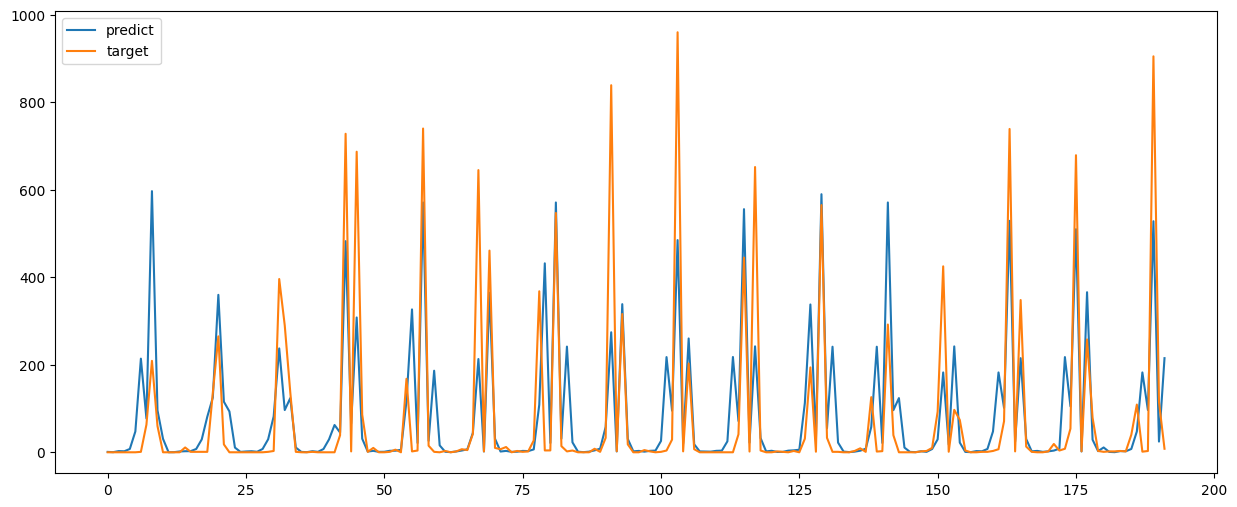

In [400]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [401]:
MSE(y_train_full, prev_train)

14521.362646506059

In [402]:
prev_test = modelo.predict(X_test)

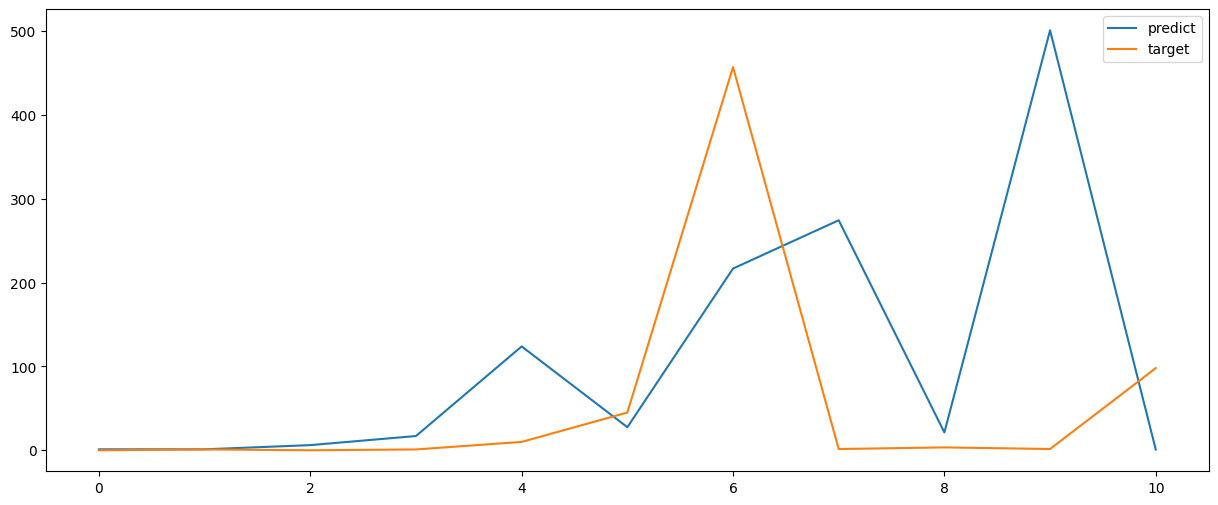

In [403]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [404]:
MSE(y_test, prev_test)

36802.60021992022